# Implementing DNN model with MNIST dataset

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [10]:
batch_size = 12

train_data = datasets.MNIST("D:/datasets", train=True, download=True,transform=transforms.ToTensor())
test_data = datasets.MNIST("D:/datasets",train=False,download=True,transform=transforms.ToTensor())

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_data,batch_size = batch_size)

In [11]:
class MLP(nn.Module):
    def __init__(self, hidden_units = [512,256,128,64]):
        super().__init__()
        
        self.in_dim = 28*28 # MNIST
        self.out_dim = 10
        
        self.l_layers = []
        self.l_layers.append(nn.Linear(self.in_dim,hidden_units[0]))
        for i in range(len(hidden_units)-1) :
            self.l_layers.append(nn.Linear(hidden_units[i],hidden_units[i+1]))
        self.l_layers.append(nn.Linear(hidden_units[-1],self.out_dim))
        
        self.l_layers = nn.ModuleList(self.l_layers)
        
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax()
        
    def forward(self,x):
        a = x.view(-1,self.in_dim)
        output_list = []
        
        for i in range(len(self.l_layers)) :
            z = self.l_layers[i](a)
            output_list.append(z)
            if i != len(self.l_layers) -1 :
                a = self.relu(z)
            output_list.append(a)
                        
        return output_list[-1], output_list

In [12]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [62]:
# Train
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs: data is a list of [inputs, labels]
        inputs, labels = data
        
        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward + optimize
        outputs,_ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if (i+1) % 2000 == 0:
            print("[%d, %5d] loss : %.3f" %
                 (epoch+1, i+1, running_loss/2000))
            running_loss = 0

print("Finished Training")

[1,  2000] loss : 0.026
[1,  4000] loss : 0.026
[2,  2000] loss : 0.022
[2,  4000] loss : 0.020
[3,  2000] loss : 0.015
[3,  4000] loss : 0.018
[4,  2000] loss : 0.014
[4,  4000] loss : 0.012
[5,  2000] loss : 0.010
[5,  4000] loss : 0.010
[6,  2000] loss : 0.007
[6,  4000] loss : 0.008


KeyboardInterrupt: 

In [14]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

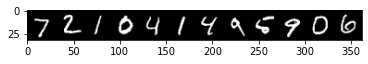

GroundTruth
   7   2   1   0   4   1   4   9   5   9   0   6
Prediction
   7   2   1   0   4   1   4   9   5   9   0   6


In [16]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images, nrow=batch_size))
print("GroundTruth")
print(" "+" ".join("%3s"%label.item() for label in labels))

outputs,_ = model(images)
_,predicted = torch.max(outputs,1)
print("Prediction")
print(" "+" ".join("%3s"%label.item() for label in predicted))

In [61]:
n_predict = 0
n_correct = 0

for data in test_loader:
    inputs, labels = data
    outputs,_ = model(inputs)
    _, predicted = torch.max(outputs,1)
    
    n_predict += len(predicted)
    n_correct += (labels == predicted).sum()
    
print(f"{n_correct}/{n_predict}")
print(f"Accuracy: {n_correct/n_predict: .3f}")

9719/10000
Accuracy:  0.972


## Implementing MNIST data for PCA & TCNE

In [46]:
from __future__ import print_function
import time
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

%matplotlib inline

In [47]:
#Load MNIST data
mnist = fetch_openml('mnist_784',version=1,cache=True)
X = mnist.data / 255.0
Y = mnist.target

In [48]:
print(f'X.shape : {X.shape}')
print(f'Y.shape : {Y.shape}')

X.shape : (70000, 784)
Y.shape : (70000,)


In [49]:
feat_cols = [f'pixel{i}' for i in range(X.shape[1])]
df = pd.DataFrame(X.values,columns=feat_cols)
df['y'] = Y

In [50]:
# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])
rndperm.shape

(70000,)

<Figure size 432x288 with 0 Axes>

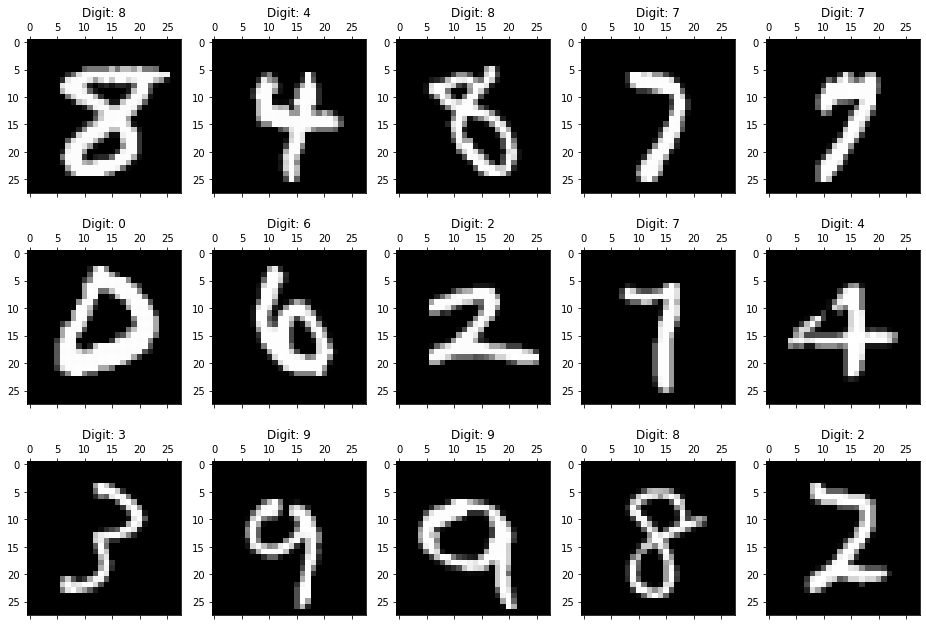

In [51]:
plt.gray()
fig = plt.figure(figsize=(16,11))
for i in range(0,15):
    ax =fig.add_subplot(3,5,i+1,title="Digit: {}".format(str(df.loc[rndperm[i],'y'])))
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))
plt.show()

# PCA & tSNE

In [52]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1]
print('Explained variation per principal components: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal components: [0.09746116 0.07155445]


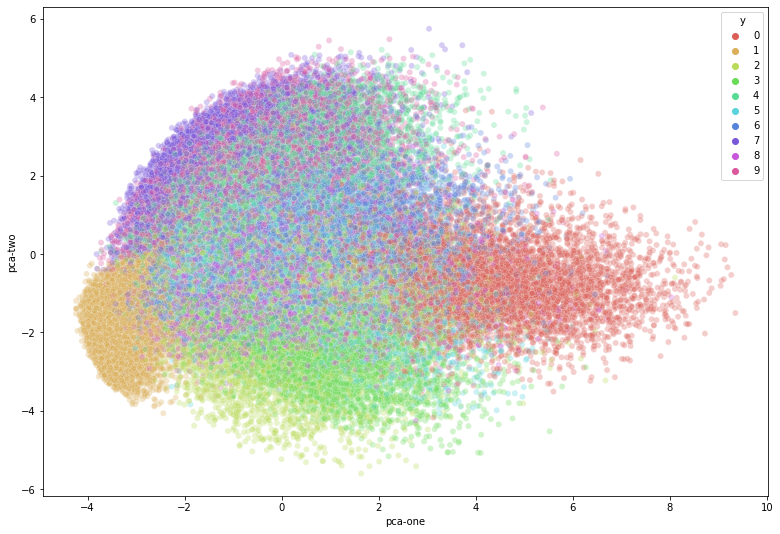

In [53]:
plt.figure(figsize=(13,9))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls",10),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)
plt.show()

Explained variation per principal components: [0.09819946 0.07123677]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.004s...
[t-SNE] Computed neighbors for 10000 samples in 2.718s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.117975
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.998169
[t-SNE] 

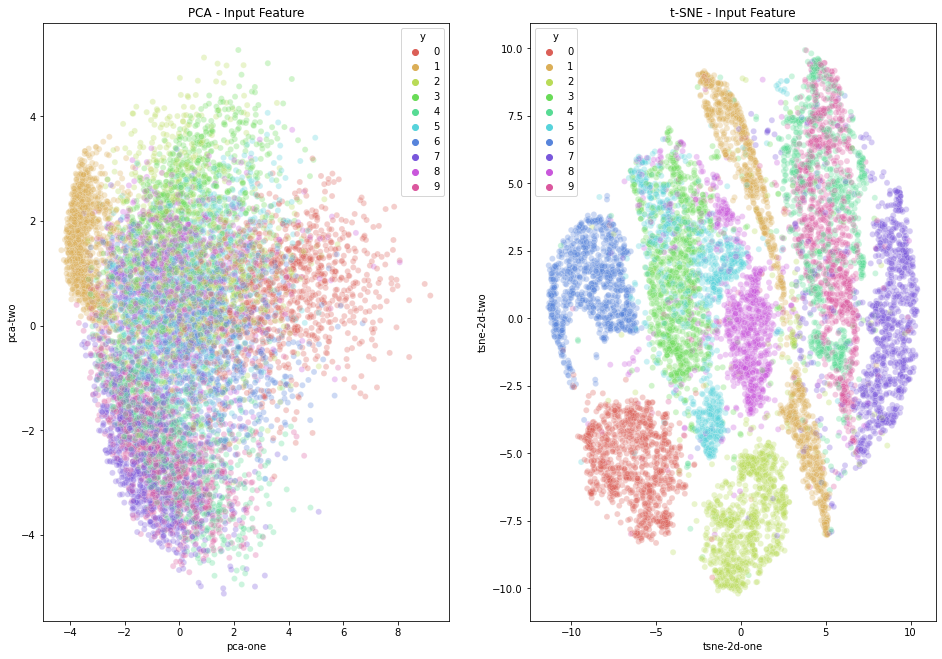

In [143]:
feat_cols = [f'pixel{i}' for i in range(X.shape[1])]
df = pd.DataFrame(X.values,columns=feat_cols)
df['y'] = Y


# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])
rndperm.shape

N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1]
print('Explained variation per principal components: {}'.format(pca.explained_variance_ratio_))

# t-SNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
print('t-SNE done! time elapsed: {} seconds'.format(time.time()-time_start))

plt.figure(figsize=(16,11))
plt.subplot(1,2,1)
plt.title("PCA - Input Feature")
sns.scatterplot(
    x=df_subset["pca-one"], y=df_subset["pca-two"],
    hue="y",
    palette=sns.color_palette("hls",10),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

plt.subplot(1,2,2)
plt.title("t-SNE - Input Feature")
sns.scatterplot(
    x=df_subset["tsne-2d-one"], y=df_subset["tsne-2d-two"],
    hue="y",
    palette=sns.color_palette("hls",10),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

plt.savefig("Input Feature")

In [85]:
output, w_list = model(torch.tensor(X.values,dtype=torch.float))

In [89]:
len(w_list)

10

In [90]:
w_list[0].shape

torch.Size([70000, 512])

In [134]:
feat_column = [f'feature{i}' for i in range(w_list[9].shape[1])]
df_test = pd.DataFrame(w_list[9].detach().numpy(),columns=feat_column)

In [135]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_test[feat_column].values)
df_test['pca-one'] = pca_result[:,0]
df_test['pca-two'] = pca_result[:,1]

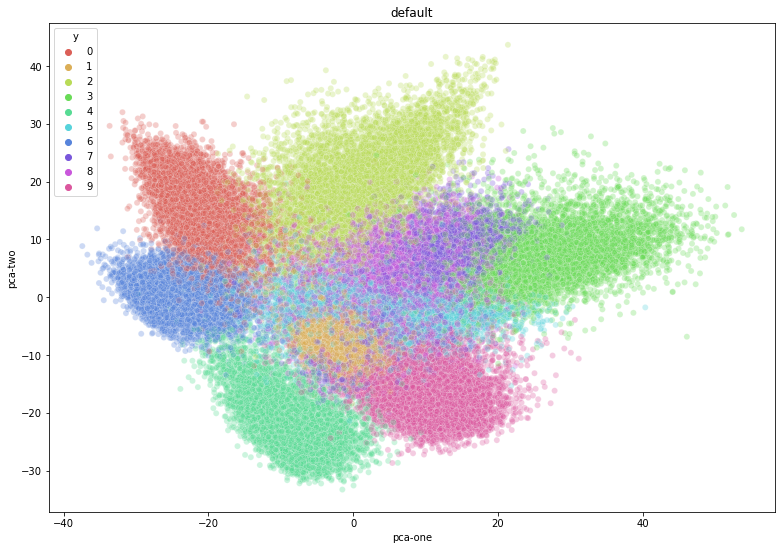

In [139]:
plt.figure(figsize=(13,9))
plt.title("default")
sns.scatterplot(
    x=df_test["pca-one"], y=df_test["pca-two"],
    hue="y",
    palette=sns.color_palette("hls",10),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)
plt.show()

In [140]:
feat_column = [f'feature{i}' for i in range(w_list[9].shape[1])]
df_test2 = pd.DataFrame(w_list[9].detach().numpy(),columns=feat_column)

In [126]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_test2)
df_test2['tsne-2d-one'] = tsne_results[:,0]
df_test2['tsne-2d-two'] = tsne_results[:,1]
print('t-SNE done! time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 70000 samples in 0.004s...
[t-SNE] Computed neighbors for 70000 samples in 97.903s...
[t-SNE] Computed conditional probabilities for sample 1000 / 70000
[t-SNE] Computed conditional probabilities for sample 2000 / 70000
[t-SNE] Computed conditional probabilities for sample 3000 / 70000
[t-SNE] Computed conditional probabilities for sample 4000 / 70000
[t-SNE] Computed conditional probabilities for sample 5000 / 70000
[t-SNE] Computed conditional probabilities for sample 6000 / 70000
[t-SNE] Computed conditional probabilities for sample 7000 / 70000
[t-SNE] Computed conditional probabilities for sample 8000 / 70000
[t-SNE] Computed conditional probabilities for sample 9000 / 70000
[t-SNE] Computed conditional probabilities for sample 10000 / 70000
[t-SNE] Computed conditional probabilities for sample 11000 / 70000
[t-SNE] Computed conditional probabilities for sample 12000 / 70000
[t-SNE] Computed conditional probabilities for s

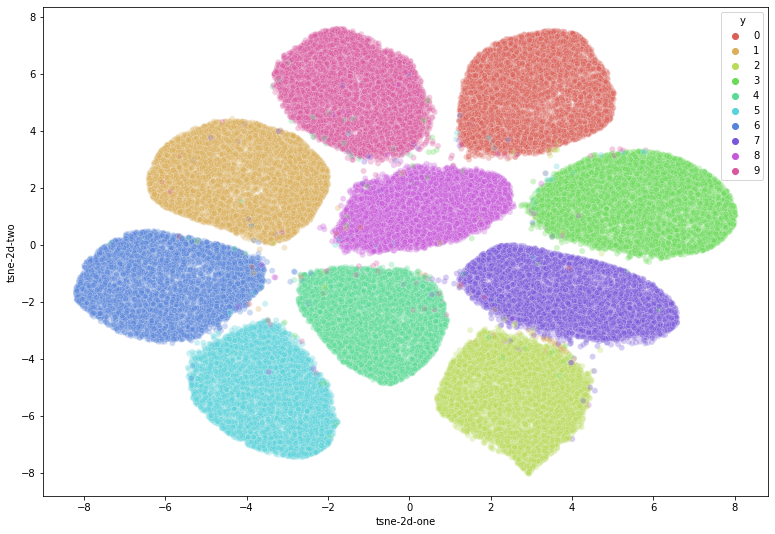

In [127]:
plt.figure(figsize=(13,9))
sns.scatterplot(
    x=df_test2["tsne-2d-one"], y=df_test2["tsne-2d-two"],
    hue="y",
    palette=sns.color_palette("hls",10),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)
plt.show()

In [133]:
for i in range(0,10,2) :
    print(i)

0
2
4
6
8
